In [3]:
import torch 
import random
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch.nn as nn
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torchmetrics.image.fid import FrechetInceptionDistance
import torchmetrics
from torchvision.utils import make_grid
import pandas as pd
import torchvision
import numpy as np

In [4]:

apples='/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Apple Red Yellow 1'
cherry='/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Cherry 1'
kiwi='/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Kiwi 1'

In [5]:
import os

file_paths = []
labels = []
#mixed_quality_dir = ""
def process_directory(directory, file_path, labels):
    # for subfolder_name in os.listdir(directory):
    #     subfolder_path = os.path.join(directory, subfolder_name)
    #     if os.path.isdir(subfolder_path):
            for file_name in os.listdir(directory):
                if file_name.endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(directory, file_name)
                    file_paths.append(file_path)
                    label = f"{os.path.basename(directory)}"
                    labels.append(label)

process_directory(apples, file_paths, labels)
process_directory(cherry, file_paths, labels)
process_directory(kiwi, file_paths, labels)



In [6]:

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
combined_data = pd.DataFrame({
    'file_path':file_paths,
    'label': encoded_labels 
})

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping")
for label, encoded_label in label_mapping.items():
    ct = labels.count(label)
    print(f"{label}: {encoded_label}, {ct}")

Label Encoding Mapping
Apple Red Yellow 1: 0, 492
Cherry 1: 1, 492
Kiwi 1: 2, 466


In [7]:
class FruitDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform

    def __len__(self):
         return len(self.data_frame)

    def __getitem__(self, idx):
          img_path = self.data_frame.iloc[idx, 0]
          label = self.data_frame.iloc[idx, 1]           # label column
          label = torch.tensor(label, dtype=torch.long) 
          image = Image.open(img_path).convert('RGB')
          if self.transform:
              image = self.transform(image)

          return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
import os
import cv2

folder_path = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Apple Red Yellow 1"
files = os.listdir(folder_path)
image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

images = []
for file in image_files:
    img_path = os.path.join(folder_path, file)
    img = cv2.imread(img_path)
    images.append(img)

Batch shape: torch.Size([64, 3, 64, 64])
Label shape: torch.Size([64])


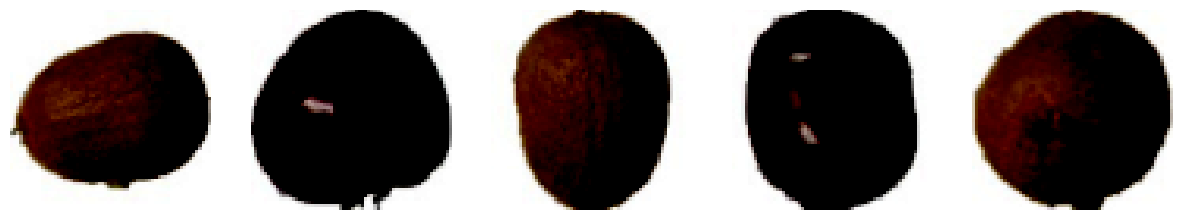

In [12]:
import matplotlib.pyplot as plt
fruit_dataset = FruitDataset(data_frame=combined_data, transform=transform)
dataloader = DataLoader(fruit_dataset, batch_size=64, shuffle=True,)

for images, labels in dataloader:
    print("Batch shape:", images.shape)  
    print("Label shape:", labels.shape)
    break
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for idx in range(5):
    img = images[idx]
    img = img.permute(1, 2, 0).cpu().numpy()
    axs[idx].imshow(img)
    axs[idx].axis('off')

plt.show()

In [13]:
for images, labels in dataloader:
    print("Batch shape:", images.shape)  
    print("Label shape:", labels.shape)
    break


Batch shape: torch.Size([64, 3, 64, 64])
Label shape: torch.Size([64])


In [14]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 300

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
    
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
    
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
    
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
    
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
    
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
    
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        return img

   

In [16]:
from torchinfo import summary

model = Generator(100)

summary(model, input_size=(1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Linear: 2-1                       [1, 8192]                 827,392
│    └─ReLU: 2-2                         [1, 8192]                 --
│    └─Unflatten: 2-3                    [1, 128, 8, 8]            --
│    └─Upsample: 2-4                     [1, 128, 16, 16]          --
│    └─Conv2d: 2-5                       [1, 128, 16, 16]          147,584
│    └─BatchNorm2d: 2-6                  [1, 128, 16, 16]          256
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └─Upsample: 2-8                     [1, 128, 32, 32]          --
│    └─Conv2d: 2-9                       [1, 64, 32, 32]           73,792
│    └─BatchNorm2d: 2-10                 [1, 64, 32, 32]           128
│    └─ReLU: 2-11                        [1, 64, 32, 32]           --

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(256 * 5 * 5 ,1),

        )
    def forward(self, img):
        validity = self.model(img)
        return validity
    

In [18]:
from torchinfo import summary

model = Discriminator()

summary(model, input_size=(1,3,64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─LeakyReLU: 2-2                    [1, 32, 32, 32]           --
│    └─Dropout: 2-3                      [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 16, 16]           18,496
│    └─ZeroPad2d: 2-5                    [1, 64, 17, 17]           --
│    └─BatchNorm2d: 2-6                  [1, 64, 17, 17]           128
│    └─LeakyReLU: 2-7                    [1, 64, 17, 17]           --
│    └─Dropout: 2-8                      [1, 64, 17, 17]           --
│    └─Conv2d: 2-9                       [1, 128, 9, 9]            73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 9, 9]            256
│    └─LeakyReLU: 2-11                   [1, 128, 9, 9]            --
│   

In [19]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCEWithLogitsLoss()

optimizer_G = optim.Adam(generator.parameters(),lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(beta1, beta2))

Epoch [1/300] Batch 20/23 Discriminator Loss: 0.2683 Generator Loss: 1.5186
Epoch [2/300] Batch 20/23 Discriminator Loss: 0.4611 Generator Loss: 1.2141
Epoch [3/300] Batch 20/23 Discriminator Loss: 0.5072 Generator Loss: 1.0127
Epoch [4/300] Batch 20/23 Discriminator Loss: 0.5274 Generator Loss: 1.1186
Epoch [5/300] Batch 20/23 Discriminator Loss: 0.4534 Generator Loss: 1.4091
Epoch [6/300] Batch 20/23 Discriminator Loss: 0.4678 Generator Loss: 1.6651
Epoch [7/300] Batch 20/23 Discriminator Loss: 0.5122 Generator Loss: 1.3130
Epoch [8/300] Batch 20/23 Discriminator Loss: 0.5584 Generator Loss: 1.1397
Epoch [9/300] Batch 20/23 Discriminator Loss: 0.4952 Generator Loss: 1.4766
Epoch [10/300] Batch 20/23 Discriminator Loss: 0.5803 Generator Loss: 0.7985
Epoch [11/300] Batch 20/23 Discriminator Loss: 0.5217 Generator Loss: 1.1760
Epoch [12/300] Batch 20/23 Discriminator Loss: 0.5207 Generator Loss: 1.2549
Epoch [13/300] Batch 20/23 Discriminator Loss: 0.5304 Generator Loss: 1.3443
Epoch [1

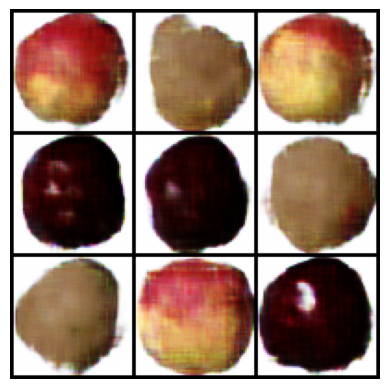

Epoch [51/300] Batch 20/23 Discriminator Loss: 0.5025 Generator Loss: 1.2888
Epoch [52/300] Batch 20/23 Discriminator Loss: 0.3814 Generator Loss: 1.3867
Epoch [53/300] Batch 20/23 Discriminator Loss: 0.4548 Generator Loss: 1.0641
Epoch [54/300] Batch 20/23 Discriminator Loss: 0.5237 Generator Loss: 1.3783
Epoch [55/300] Batch 20/23 Discriminator Loss: 0.4450 Generator Loss: 1.2846
Epoch [56/300] Batch 20/23 Discriminator Loss: 0.6053 Generator Loss: 1.1372
Epoch [57/300] Batch 20/23 Discriminator Loss: 0.4593 Generator Loss: 1.0788
Epoch [58/300] Batch 20/23 Discriminator Loss: 0.4402 Generator Loss: 1.3415
Epoch [59/300] Batch 20/23 Discriminator Loss: 0.4523 Generator Loss: 1.1800
Epoch [60/300] Batch 20/23 Discriminator Loss: 0.4930 Generator Loss: 1.4339
Epoch [61/300] Batch 20/23 Discriminator Loss: 0.4737 Generator Loss: 1.3189
Epoch [62/300] Batch 20/23 Discriminator Loss: 0.4886 Generator Loss: 1.1670
Epoch [63/300] Batch 20/23 Discriminator Loss: 0.4148 Generator Loss: 1.3817

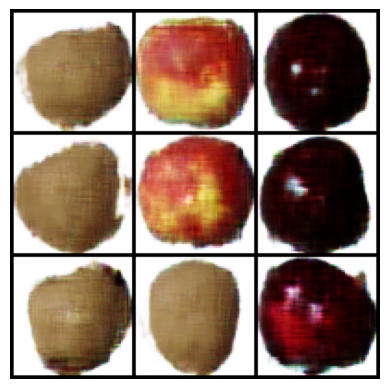

Epoch [101/300] Batch 20/23 Discriminator Loss: 0.4211 Generator Loss: 1.6632
Epoch [102/300] Batch 20/23 Discriminator Loss: 0.4965 Generator Loss: 1.4524
Epoch [103/300] Batch 20/23 Discriminator Loss: 0.4090 Generator Loss: 1.7631
Epoch [104/300] Batch 20/23 Discriminator Loss: 0.3906 Generator Loss: 1.7309
Epoch [105/300] Batch 20/23 Discriminator Loss: 0.3411 Generator Loss: 1.6857
Epoch [106/300] Batch 20/23 Discriminator Loss: 0.3900 Generator Loss: 1.5793
Epoch [107/300] Batch 20/23 Discriminator Loss: 0.4672 Generator Loss: 1.3519
Epoch [108/300] Batch 20/23 Discriminator Loss: 0.4220 Generator Loss: 1.4821
Epoch [109/300] Batch 20/23 Discriminator Loss: 0.4007 Generator Loss: 1.7763
Epoch [110/300] Batch 20/23 Discriminator Loss: 0.4528 Generator Loss: 1.3871
Epoch [111/300] Batch 20/23 Discriminator Loss: 0.5003 Generator Loss: 1.3990
Epoch [112/300] Batch 20/23 Discriminator Loss: 0.4108 Generator Loss: 1.7542
Epoch [113/300] Batch 20/23 Discriminator Loss: 0.4491 Generator

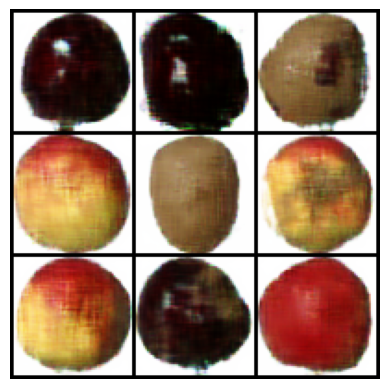

Epoch [151/300] Batch 20/23 Discriminator Loss: 0.4158 Generator Loss: 2.1087
Epoch [152/300] Batch 20/23 Discriminator Loss: 0.3611 Generator Loss: 2.0280
Epoch [153/300] Batch 20/23 Discriminator Loss: 0.3615 Generator Loss: 1.6437
Epoch [154/300] Batch 20/23 Discriminator Loss: 0.4370 Generator Loss: 1.7980
Epoch [155/300] Batch 20/23 Discriminator Loss: 0.5048 Generator Loss: 2.1403
Epoch [156/300] Batch 20/23 Discriminator Loss: 0.3714 Generator Loss: 1.9231
Epoch [157/300] Batch 20/23 Discriminator Loss: 0.3421 Generator Loss: 1.8429
Epoch [158/300] Batch 20/23 Discriminator Loss: 0.3314 Generator Loss: 2.4021
Epoch [159/300] Batch 20/23 Discriminator Loss: 0.4040 Generator Loss: 1.6874
Epoch [160/300] Batch 20/23 Discriminator Loss: 0.3084 Generator Loss: 1.7901
Epoch [161/300] Batch 20/23 Discriminator Loss: 0.3136 Generator Loss: 1.6879
Epoch [162/300] Batch 20/23 Discriminator Loss: 0.3232 Generator Loss: 2.1471
Epoch [163/300] Batch 20/23 Discriminator Loss: 0.3491 Generator

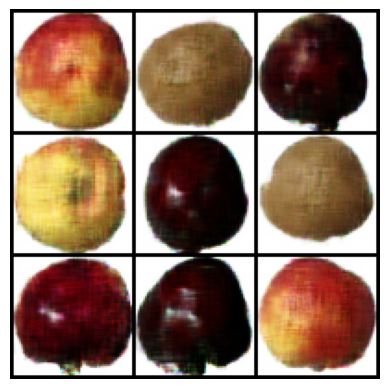

Epoch [201/300] Batch 20/23 Discriminator Loss: 0.2543 Generator Loss: 1.8717
Epoch [202/300] Batch 20/23 Discriminator Loss: 0.2650 Generator Loss: 2.4840
Epoch [203/300] Batch 20/23 Discriminator Loss: 0.2786 Generator Loss: 2.5596
Epoch [204/300] Batch 20/23 Discriminator Loss: 0.3225 Generator Loss: 1.7916
Epoch [205/300] Batch 20/23 Discriminator Loss: 0.2782 Generator Loss: 2.0938
Epoch [206/300] Batch 20/23 Discriminator Loss: 0.3290 Generator Loss: 2.0735
Epoch [207/300] Batch 20/23 Discriminator Loss: 0.3316 Generator Loss: 2.2787
Epoch [208/300] Batch 20/23 Discriminator Loss: 0.2907 Generator Loss: 2.0676
Epoch [209/300] Batch 20/23 Discriminator Loss: 0.3698 Generator Loss: 1.9869
Epoch [210/300] Batch 20/23 Discriminator Loss: 0.2776 Generator Loss: 2.3968
Epoch [211/300] Batch 20/23 Discriminator Loss: 0.2190 Generator Loss: 2.6494
Epoch [212/300] Batch 20/23 Discriminator Loss: 0.2660 Generator Loss: 2.2732
Epoch [213/300] Batch 20/23 Discriminator Loss: 0.3691 Generator

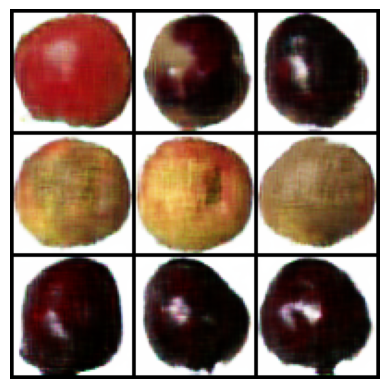

Epoch [251/300] Batch 20/23 Discriminator Loss: 0.1640 Generator Loss: 2.5782
Epoch [252/300] Batch 20/23 Discriminator Loss: 0.1829 Generator Loss: 2.4350
Epoch [253/300] Batch 20/23 Discriminator Loss: 0.2162 Generator Loss: 3.0868
Epoch [254/300] Batch 20/23 Discriminator Loss: 0.2672 Generator Loss: 2.3512
Epoch [255/300] Batch 20/23 Discriminator Loss: 0.2134 Generator Loss: 2.6928
Epoch [256/300] Batch 20/23 Discriminator Loss: 0.2544 Generator Loss: 2.2952
Epoch [257/300] Batch 20/23 Discriminator Loss: 0.2111 Generator Loss: 3.2112
Epoch [258/300] Batch 20/23 Discriminator Loss: 0.2669 Generator Loss: 2.4330
Epoch [259/300] Batch 20/23 Discriminator Loss: 0.2416 Generator Loss: 2.8825
Epoch [260/300] Batch 20/23 Discriminator Loss: 0.3000 Generator Loss: 2.3179
Epoch [261/300] Batch 20/23 Discriminator Loss: 0.2560 Generator Loss: 2.7521
Epoch [262/300] Batch 20/23 Discriminator Loss: 0.2456 Generator Loss: 2.7944
Epoch [263/300] Batch 20/23 Discriminator Loss: 0.2810 Generator

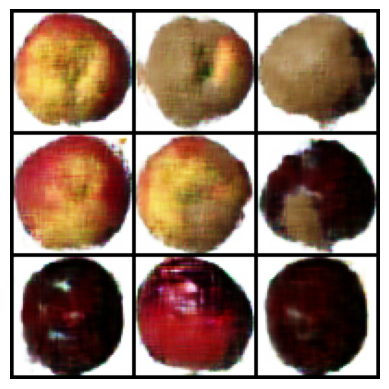

In [20]:
for epoch in range(epochs):
    generator.train(); discriminator.train()

    for i, batch in enumerate(dataloader):
        real_images = batch[0].to(device)
        N = real_images.size(0)

        # Targets
        valid = torch.ones(N, 1, device=device)
        fake  = torch.zeros(N, 1, device=device)

        # ---- D step ----
        optimizer_D.zero_grad()
        z = torch.randn(N, latent_dim, device=device)
        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)
        d_loss.backward()
        optimizer_D.step()

        # ---- G step ----
        optimizer_G.zero_grad()
        # optional: z = torch.randn(N, latent_dim, device=device)
        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 20 == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}] Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )

    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            z = torch.randn(9, latent_dim, device=device)
            generated = generator(z).cpu()
            grid = torchvision.utils.make_grid(generated, nrow=3, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()
